# Part B


In [8]:
import pandas as pd
import numpy as np
from collections import namedtuple
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, classification_report

sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
data = pd.read_csv('/Users/utility/Downloads/Reviews2.csv', sep=",", header = 'infer')

Sentiment Score

In [10]:
print("Average Score: ",np.mean(data.Score))
print("Median Score: ",np.median(data.Score))

Average Score:  4.183198640523243
Median Score:  5.0


As we can observe, the majority of Scores are equal to 4 and 5, and with an average score of 4.18. Because of the distribution is very skewed to the left, we will make a binary prediction. We can consider a negative review will have a Score between 1 and 3, and a positive review will have a Score equal to 4 or 5.

/Users/utility/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


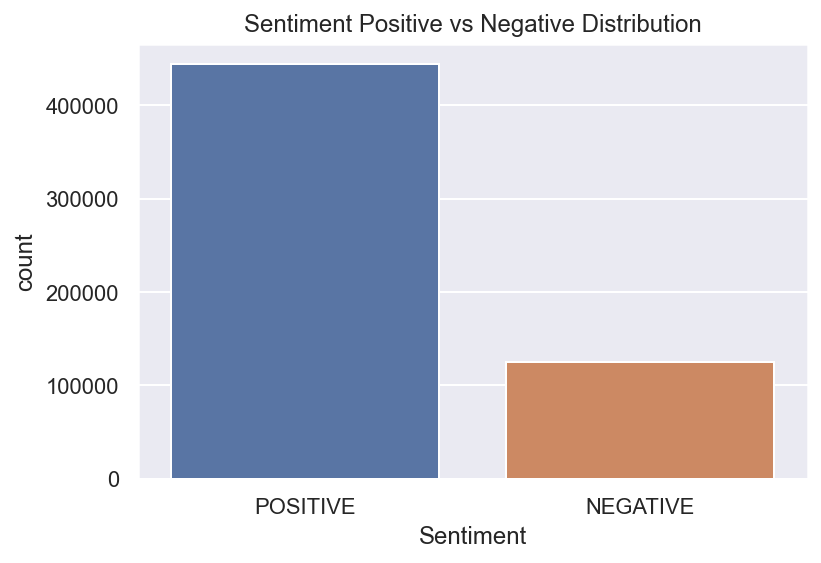

In [12]:
data.loc[data.Score>3,'Sentiment']="POSITIVE"
data.loc[data.Score<=3,'Sentiment']="NEGATIVE"
ax = plt.axes()
sns.countplot(data.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [13]:
print("Proportion of positive review:", len(data[data.Sentiment=="POSITIVE"])/len(data))
print("Proportion of positive review:",len(data[data.Sentiment=="NEGATIVE"])/len(data))

Proportion of positive review: 0.7806735461444549
Proportion of positive review: 0.21932645385554503


With this new classification, 78.067% of the fine food reviews are considered as positive and 22% of them are considered as negative.

In [18]:
reviews = data.Text.values
labels = data.Sentiment.values

### Text Reviews

First wil discover the full sentence.

In [20]:
def pretty_print_review_and_label(i):
    if data.Sentiment[i]=="POSITIVE":
        print("POSITIVE" + "\t" + reviews[i])
    else:
        print("NEGATIVE" + "\t " + reviews[i])

In [24]:
pretty_print_review_and_label(200)

NEGATIVE	 Even with small containers, they don't fill them up.  These little tins are less than half filled and at the price charged it seems a rip-off. Is there some exotic ingredient as costly as gold contained in those tiny squares?  Or how about the cereal ploy, they were filled at the factory but settled in transport.<br />Can manufacturers be honest in their dealings?


In [26]:
pretty_print_review_and_label(222)

POSITIVE	I have tried literally dozens of teas since being introduced to the Russian custom of preparing and drinking tea, and the Ahmad Imperial blend is probably my favorite of all of these due to the fact that it is equally delicious hot or iced.  I buy the three-packs as needed from Amazon and go through them rapidly. My family loves it and my friends have it in their homes now too, try one box of it and you will love it too.


In [27]:
pretty_print_review_and_label(315)

POSITIVE	This brand of coffee has been available in my local stores for some time -- I've believe the company is local.  I've been drinking it for quite some time and have not tired of it.  I'm particularly fond of the Turtle Sundae but all the flavors are good.  I can't say that I've had a bad one.<br /><br />As it turns out, it's less expensive to order it from Amazon and have it show up at my front door than it is for me to run out to the local Walmart to get it.  It's a no brainer.  Try it, if you like rich, flavored coffee, you'll like it.


In [28]:
pretty_print_review_and_label(1314)

POSITIVE	It's always wonderful to be able to give chocolates as a gift and to receive them.  It's great to know that you can send someone  some chocolates with the guarantee that they don't arrive all melted.  Good Service and Excellent chocolates!


In [29]:
pretty_print_review_and_label(5566)

NEGATIVE	 this egg pasta ingredient was "powdered egg product" and as such not as tasty as those containing the real thing.  i don't like anything powdered, but price was RIGHT.  can't have it all i guess.


In [31]:
pretty_print_review_and_label(6699)

NEGATIVE	 This product taste like an orange juice, an artificial one but with less sugar and less flavor I didn't like it.


In [34]:
pretty_print_review_and_label(12305)

NEGATIVE	 I have purchased numerous canned chicken products before, and of course none compare to real chicken.  However, that being said, this product's quality is considerably below that of most canned chickens.  Other canned chickens have large chunks of white meat, while this product is full of small discolored pieces with pieces of what appear to be skin or fat.  Considering the price is also higher than the store bought competitors, I can not recommend this product.


In [43]:
pretty_print_review_and_label(66667)

POSITIVE	My foie gras arrived quickly and fully frozen. I was able to easily separate it into two pieces to save one lobe for later. There was only the one connecting vein in the middle so prep was minimal.


let's look at more positive/negative comments:

In [32]:
def non_full_pretty_print_review_and_label(i):
    if data.Sentiment[i]=="POSITIVE":
        print("POSITIVE" + "\t" + reviews[i][:90] + "...")
    else:
        print("NEGATIVE" + "\t " + reviews[i][:90] + "...")

In [59]:
non_full_pretty_print_review_and_label(5599)
non_full_pretty_print_review_and_label(5563)
non_full_pretty_print_review_and_label(14155)
non_full_pretty_print_review_and_label(5574)

POSITIVE	This coffee is better than McDonalds, StarBucks, Atlanta Bread, Folgers, Maxwell House and...
NEGATIVE	 I dont like the taste of this at all.  I have some other fennel tea from another company n...
POSITIVE	I love all of Newman's Own products, and I like that their dog treats are all-natural and ...
NEGATIVE	 I was really disappointed in these olives. The are very mushy and I prefer a more firm tex...


A common approach to distinguish positive from negative reviews is to look at the frequency of the words. We can imagine that certain words, such as "excellent" or "very tasty," tend to occur more often in positive reviews than negative reviews. Let's see if we can validate this theory.

In [60]:
non_full_pretty_print_review_and_label(8665)
non_full_pretty_print_review_and_label(55444)
non_full_pretty_print_review_and_label(12345)
non_full_pretty_print_review_and_label(5574)

NEGATIVE	 If Keurig brewers were evaluated by this particular K-Cup, Keurig would be out of business...
POSITIVE	He brings me his Kong whenever I'm in the kitchen, without me having to ask him anymore. I...
POSITIVE	I bought these on super sale because I needed them for a pie crust and they were cheap.  I...
NEGATIVE	 I was really disappointed in these olives. The are very mushy and I prefer a more firm tex...


In [44]:
positive_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="POSITIVE"]
negative_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="NEGATIVE"]

from collections import Counter

cnt_positve = Counter()

for row in positive_reviews:
    cnt_positve.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_positve.keys()))

cnt_negative = Counter()

for row in negative_reviews:
    cnt_negative.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_negative.keys()))

cnt_total = Counter()

for row in reviews:
    cnt_total.update(row.split(" "))

pos_neg_ratio = Counter()
vocab_pos_neg = (set(cnt_positve.keys())).intersection(set(cnt_negative.keys()))
for word in vocab_pos_neg:
    if cnt_total[word]>100:
        ratio = cnt_positve[word]/float(cnt_negative[word]+1)
        if ratio>1:
            pos_neg_ratio[word] = np.log(ratio)
        else:
            pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 

Vocabulary size for positve reviews: 480349
Vocabulary size for positve reviews: 239355


After calculating the ratio between the frequency count in the positive review divided by the frequency count in the negative review for each word, here are the results:

When the ratio is high (greater than 1), it means than the words tend to occur more often in positive reviews than in negative reviews.

In [45]:
pos_neg_ratio .most_common()[:30]

[('/>Highly', 5.791488055075306),
 ('anytime.', 5.147494476813453),
 ('soothing.', 4.912654885736052),
 ('addictive!', 4.897839799950911),
 ('Enjoy.', 4.840242308167575),
 ('/>Magnesium', 4.721470641684252),
 ('/>Almonds', 4.709530201312334),
 ('versatile.', 4.6443908991413725),
 ('Rich,', 4.634728988229636),
 ('organs.', 4.532599493153256),
 ('hooked.', 4.516338972281476),
 ('Delicious!', 4.496630017412885),
 ('diet?', 4.448516375942715),
 ('/>1st', 4.442651256490317),
 ('Cakesters', 4.382026634673881),
 ('Booda', 4.377851263263401),
 ('far!', 4.3694478524670215),
 ('*****<br', 4.3652195163575005),
 ('Favorites"', 4.33729074083249),
 ('Sciences', 4.33729074083249),
 ('synthesis.', 4.33729074083249),
 ('Highly', 4.3313052590894525),
 ('Chili<br', 4.31748811353631),
 ('addicted!', 4.310799125385514),
 ('plus!', 4.30406509320417),
 ('favorites!', 4.30406509320417),
 ('Delicious.', 4.298645025734831),
 ('Yummy!', 4.295015257684252),
 ('disappoint!', 4.283586561860629),
 ('recommended!', 4

<ipython-input-46-e91ee1e1253b>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


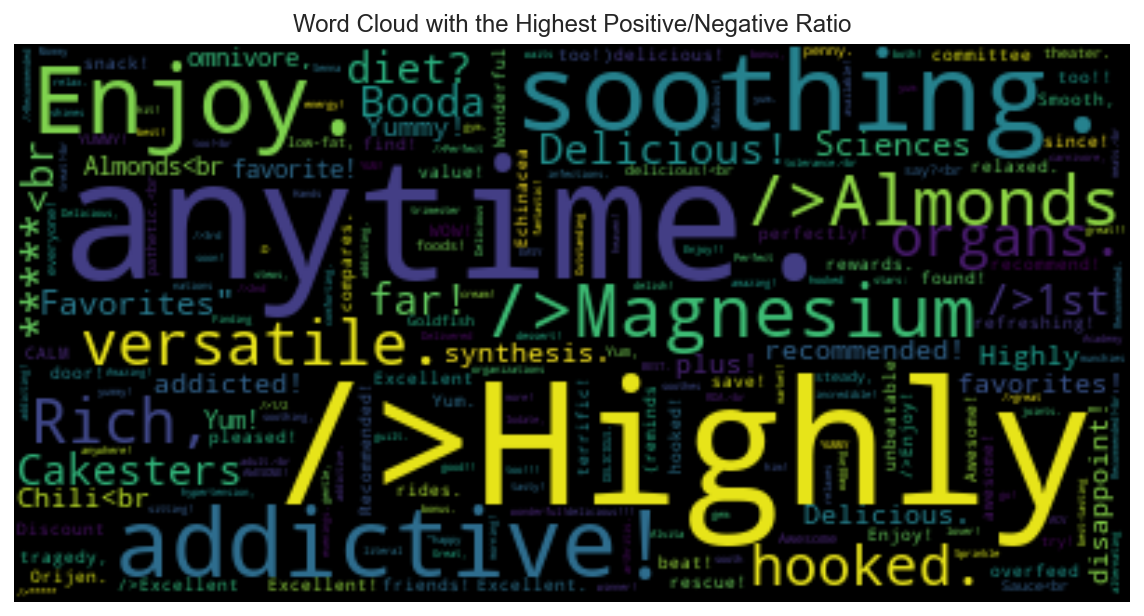

In [46]:
positive_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt>1):
        positive_dict[word] = cnt

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=positive_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Highest Positive/Negative Ratio')
plt.show()

Let's look now at the words that tend to occur more often in negative reviews than in positive reviews.

In [47]:
list(reversed(pos_neg_ratio.most_common()))[0:30]

[('FREAKS', -4.203010866014426),
 ('factory)', -4.201364829298291),
 ('judgment,', -4.201364829298291),
 ('mistakes.<br', -3.914513666740598),
 ('howling,', -3.912023005428146),
 ('NO<br', -3.328075116833193),
 ('sad.<br', -3.248146207168314),
 ('Reducing', -3.2188758248682006),
 ('Lives,', -3.2188758248682006),
 ('slaughterhouse', -3.1778728512505374),
 ('ANYMORE.', -3.1424854222041994),
 ('(good,', -3.1088233633266724),
 ('mischief.', -3.101092789211817),
 ('blue)', -2.9045009573244873),
 ('disappointment!', -2.8650573056222033),
 ('crying,', -2.7623992656292384),
 ('5/8', -2.745951587905034),
 ('"healthy,"', -2.7375866155346618),
 ('trashing', -2.6486357670125487),
 ('deliberately', -2.5174652359649476),
 ('returnable', -2.489919191611545),
 ('disorder.', -2.4825564724430467),
 ('Halo,', -2.4427317247372873),
 ('deceptive', -2.407945608651872),
 ('Horrible', -2.399007001651061),
 ('Buyer', -2.3765230838453015),
 ('twenty-five', -2.342112073137968),
 ('horrible!', -2.2335922215070942